In [1]:
import os
import h5py
import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
fld = "D:Storage/datasets/first-break-recognition-dataset/data"
file_name = r"Halfmile3D_add_geom_sorted.hdf5"
f = dict(h5py.File(os.path.join(fld, file_name))["TRACE_DATA/DEFAULT"])

In [3]:
def get_rec_ids() -> tuple[npt.NDArray[np.int_], npt.NDArray[np.int_], int]:
    rec = np.c_[f["REC_X"][:], f["REC_Y"][:]]
    unique_recs = np.unique(rec, axis=0)
    match_x = np.abs(rec[:, 0][:, None] - unique_recs[:, 0][None, :]) == 0
    match_y = np.abs(rec[:, 1][:, None] - unique_recs[:, 1][None, :]) == 0
    return rec, np.nonzero(np.logical_and(match_x, match_y))[1], len(unique_recs)


rec, rec_ids, n_unique_recs = get_rec_ids()

In [4]:
def prepare_data_array(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int) -> list[npt.NDArray[np.float_]]:
    data_array = f["data_array"][:]
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(data_array[receiver_ids == i, :].T)
    return result

In [5]:
def prepare_shot_id(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int):
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(f["SHOTID"][:][receiver_ids == i, :].flatten())
    return result

In [6]:
def prepare_sample_rate(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int):
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(f["SAMP_RATE"][:][receiver_ids == i, :].flatten()[0])
    return result

In [7]:
def prepare_spare1(receiver_ids: npt.NDArray[np.int_], n_unique_receivers: int):
    result = []
    for i in tqdm(range(n_unique_receivers)):
        result.append(f["SPARE1"][:][receiver_ids == i, :].flatten())
    return result

In [8]:
df = pd.DataFrame(
    {
        "data_array": prepare_data_array(rec_ids, n_unique_recs),
        "rec_coord": [rec[np.where(rec_ids==i)[0][0], :] for i in range(n_unique_recs)],
        "shot_id": prepare_shot_id(rec_ids, n_unique_recs),
        "sample_rate": prepare_sample_rate(rec_ids, n_unique_recs),
        "spare1": prepare_spare1(rec_ids, n_unique_recs),
    }
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2378/2378 [00:16<00:00, 145.93it/s]


In [9]:
def prepare_shot_id_split_indices(row):
    shot_id = row["shot_id"]
    indices = np.where((np.diff(shot_id) > 5000).astype(int))[0]
    indices = np.r_[0, indices, shot_id.size]
    return indices


df["shot_id_split_indices"] = df.apply(prepare_shot_id_split_indices, axis=1)

In [10]:
def split_by_shots(row: pd.Series):
    ind = row["shot_id_split_indices"]
    row["data_array"] = [row["data_array"][:, a:b] for a, b in zip(ind, ind[1:])]
    row["shot_id"] = [row["shot_id"][a:b] for a, b in zip(ind, ind[1:])]
    row["spare1"] = [row["spare1"][a:b] for a, b in zip(ind, ind[1:])]
    row["shot_id_split_indices"] = [[a, b] for a, b in zip(ind, ind[1:])]
    return row


df = df.apply(split_by_shots, axis=1)
df = df.explode(["data_array", "shot_id", "spare1", "shot_id_split_indices"]).reset_index(drop=True)
df["time_grid"] = df.apply(lambda row: 1e-3 * np.arange(row["data_array"].shape[0]) * row["sample_rate"], axis=1)

In [11]:
df.head()

,data_array,rec_coord,shot_id,sample_rate,spare1,shot_id_split_indices,time_grid
0,"[[0.0009000493, 0.021326812, -0.001981188, 0.0...","[698463, 5245981]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[652, -1, 640, -1, 624, 608, 598, 594, 590, 58...","[0, 46]","[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16..."
1,"[[0.00025968463, 0.001776692, 0.001177756, -0....","[698463, 5245981]","[20221271, 20241007, 20241011, 20241014, 20241...",2000,"[400, 324, 322, 328, 328, 332, 340, 332, 334, ...","[46, 93]","[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16..."
2,"[[-2.206082e-05, 7.367933e-05, 0.00034438886, ...","[698463, 5245981]","[20241142, 20261130, 20261132, 20261135, 20261...",2000,"[614, 592, 584, 574, 562, 552, 544, 534, 526, ...","[93, 140]","[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16..."
3,"[[0.0012893621, -0.0004232443, 0.0013825478, 0...","[698463, 5245981]","[20261255, 20281005, 20281009, 20281015, 20281...",2000,"[256, 184, 182, 188, 192, 194, 194, 204, 214, ...","[140, 183]","[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16..."
4,"[[0.005283858, -0.0003585693, -0.0001478088, -...","[698463, 5245981]","[20281122, 20301134, 20301137, 20301140, 20301...",2000,"[568, 546, 538, 526, 516, 506, 498, 488, 478, ...","[183, 226]","[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16..."


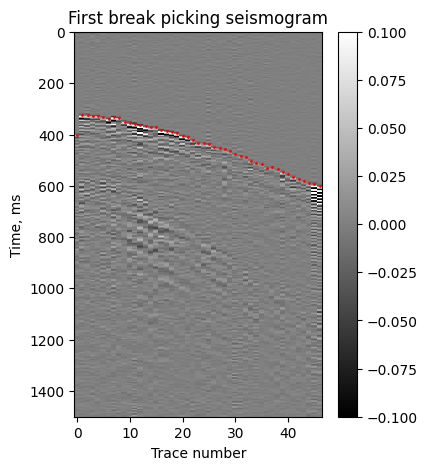

In [13]:
i = 1
x = np.arange(df["data_array"][i].shape[1], dtype=int)
y = df["time_grid"][i]
X, Y = np.meshgrid(x, y)
spare1 = df["spare1"][i]
eps = 1e-6

plt.figure(figsize=(4, 5))
plt.pcolor(X, Y, df["data_array"][i], cmap="gray", clim=(-0.1, 0.1))
plt.plot(x[spare1 > eps], spare1[spare1 > eps], ".r", ms=2)
plt.gca().invert_yaxis()
plt.ylabel("Time, ms")
plt.xlabel("Trace number")
plt.title("First break picking seismogram")
plt.colorbar()
plt.show()

In [ ]:
df["data_array_shape"] = df["data_array"].apply(lambda x: x.shape)
df["data_array"] = df["data_array"].apply(lambda x: x.flatten())
df.to_parquet(os.path.join(fld, "df.parquet.gzip"), compression="gzip")